# 📊 Classification of Image Data with Multilayer Perceptrons and Convolutional Neural Networks

**Course:** COMP 551 - Applied Machine Learning

**Institution:** McGill University  

**Group:** Giane Mayumi Galhard (51261276747), Daria Goptsii (261275056), Yixuan Qin (261010963)

**Term:** Fall 2025

---

The goal of this project is to implement a multilayer perceptron from scratch, experiment with Convolutional Neural Networks (CNNs), and utilize pre-trained versions of them to classify image data from the Fashion-MNIST dataset.

---

## Imports

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import pandas as pd


## Load dataset

In [2]:
n_threads = 8

transform = transforms.Compose([
    transforms.ToTensor(),                     # [0,1]
    transforms.Normalize((0.5,), (0.5,)),      # to roughly [-1,1] using mean=0.5, std=0.5
    transforms.Lambda(lambda x: x.view(-1)),   # flatten to [784]
])


train_dataset_full = datasets.FashionMNIST(
    root="./data", train=True,  download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

print(f"Train set: {len(train_dataset)} images")
print(f"Val set:   {len(val_dataset)} images")
print(f"Test set:  {len(test_dataset)} images")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=n_threads)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False, num_workers=n_threads)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False, num_workers=n_threads)

def loader_to_numpy(loader):
    X_list, y_list = [], []
    for xb, yb in loader:             # xb: [B, 784] tensor (already flattened), yb: [B]
        # Ensure CPU and contiguous memory; then to NumPy
        X_list.append(xb.detach().cpu().numpy())
        y_list.append(yb.detach().cpu().numpy())
    X = np.concatenate(X_list, axis=0).astype(np.float32)   # (N, 784)
    y = np.concatenate(y_list, axis=0).astype(np.int64)     # (N,)
    return X, y

X_train, y_train = loader_to_numpy(train_loader)
X_val,   y_val   = loader_to_numpy(val_loader)
X_test,  y_test  = loader_to_numpy(test_loader)

print("Shapes:")
print("  X_train:", X_train.shape, X_train.dtype, " y_train:", y_train.shape, y_train.dtype)
print("  X_val:  ", X_val.shape,   X_val.dtype,   " y_val:  ", y_val.shape,   y_val.dtype)
print("  X_test: ", X_test.shape,  X_test.dtype,  " y_test: ", y_test.shape,  y_test.dtype)


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.77MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.2MB/s]

Train set: 54000 images
Val set:   6000 images
Test set:  10000 images


Shapes:
  X_train: (54000, 784) float32  y_train: (54000,) int64
  X_val:   (6000, 784) float32  y_val:   (6000,) int64
  X_test:  (10000, 784) float32  y_test:  (10000,) int64


## MLP implementation

In [3]:
def softmax(logits):
    """
    logits: (N, C) real numbers
    returns: (N, C) probabilities summing to 1 across classes
    """
    z = logits - logits.max(axis=1, keepdims=True)  # numerical stability
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)


def one_hot(y, C):
    """
    y: (N,) integer labels in [0..C-1]
    returns: (N, C) one-hot rows
    """
    Y = np.zeros((y.shape[0], C), dtype=np.float32)
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def evaluate_acc(y_true, y_pred):
    return float((y_true == y_pred).mean())



In [4]:
class SGD:
    def __init__(self, learning_rate=1e-1, max_epochs=20, batch_size=128, shuffle=True):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.shuffle = shuffle

    def run(self, gradient_fn, X, y, params):
        N = X.shape[0]
        for epoch in range(self.max_epochs):
            idx = np.arange(N)
            if self.shuffle:
                np.random.shuffle(idx)
            for start in range(0, N, self.batch_size):
                mb = idx[start:start + self.batch_size]
                grads = gradient_fn(X[mb], y[mb], params)  # list of grads
                for p in range(len(params)):
                    params[p] -= self.learning_rate * grads[p]
        return params

In [5]:
import numpy as np

# ------------------------
# Utilities
# ------------------------
def softmax(logits):
    # logits: (N, C)
    z = logits - logits.max(axis=1, keepdims=True)  # numerical stability
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def one_hot(y, C):
    Y = np.zeros((y.shape[0], C), dtype=np.float32)
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def evaluate_acc(y_true, y_pred):
    return float((y_true == y_pred).mean())


# ------------------------
# MLP using NumPy
# ------------------------
class MLP:
    """
        input_dim:    int, e.g. 784 for 28x28 images
        hidden_sizes: list[int], e.g. [128, 64]
        num_classes:  int, e.g. 10
        activation:   'relu' | 'tanh' | 'sigmoid' (applied on hidden layers)
        weight_scale: optional float to override std of weight init
        seed:         RNG seed for reproducibility
        l2:           L2 regularization strength (applies to weights only)
    """
    _leaky_a = 0.01

    def __init__(self, input_dim, hidden_sizes, num_classes,
                 activation='relu', weight_scale=None, seed=42, l1=0.0, l2=0.0, dropout_rate=0.0):
        self.input_dim = int(input_dim)
        self.hidden_sizes = list(hidden_sizes)
        self.num_classes = int(num_classes)
        self.activation = activation.lower()
        self.l1 = float(l1)
        self.l2 = float(l2)
        self.dropout_rate = float(dropout_rate)
        rng = np.random.default_rng(seed)

        # choose init scales (He for ReLU, Xavier otherwise)
        def init_matrix(fan_in, fan_out):
            if self.activation == 'relu':  #He initialization (√(2/fan_in)) is recommended for ReLU to keep activations’ variance stable across layers.
                scale = np.sqrt(2.0 / fan_in)
            elif self.activation == 'leakyrelu':
              a = self._leaky_a
              scale = np.sqrt(2.0 / ((1.0 + a*a) * fan_in)) # He for Leaky-ReLU
            else:  # tanh/sigmoid
                scale = np.sqrt(1.0 / fan_in) #Xavier (√(1/fan_in)) is a good default for tanh/sigmoid.
            if weight_scale is not None:
                scale = weight_scale
            W = rng.normal(0.0, scale, size=(fan_in, fan_out)).astype(np.float32)
            b = np.zeros((1, fan_out), dtype=np.float32)
            return W, b

        # build layer sizes: [D, h1, h2, ..., C]
        sizes = [self.input_dim] + self.hidden_sizes + [self.num_classes]

        # parameters as a flat list: [W1, b1, W2, b2, ..., WL, bL]
        self.params = []
        for i in range(len(sizes) - 1):
            W, b = init_matrix(sizes[i], sizes[i + 1])
            self.params += [W, b]

    # ----- activations -----
    @staticmethod
    def _relu(z): return np.maximum(0.0, z)
    @staticmethod
    def _relu_grad(z): return (z > 0).astype(np.float32)
    @staticmethod
    def _tanh(z): return np.tanh(z)
    @staticmethod
    def _tanh_grad(z): return 1.0 - np.tanh(z)**2
    @staticmethod
    def _sigmoid(z): return 1.0 / (1.0 + np.exp(-z))
    @staticmethod
    def _sigmoid_grad(z):
        s = 1.0 / (1.0 + np.exp(-z))
        return s * (1.0 - s)

    @staticmethod
    def _lrelu(z, a=0.01):
      return np.where(z > 0, z, a * z)

    @staticmethod
    def _lrelu_grad(z, a=0.01):
      grad = np.ones_like(z, dtype=np.float32)
      grad[z < 0] = a
      return grad

    def _act(self, z):
        if self.activation == 'relu':   return self._relu(z)
        if self.activation == 'tanh':   return self._tanh(z)
        if self.activation == 'sigmoid':return self._sigmoid(z)
        if self.activation == 'leakyrelu':  return self._lrelu(z, a=self._leaky_a)
        raise ValueError("activation must be 'relu', 'tanh', 'sigmoid', or 'leakyrelu'")

    # Returns the gradient (derivative) of the activation function chosen above.
    def _act_grad(self, z):
        if self.activation == 'relu':   return self._relu_grad(z)
        if self.activation == 'tanh':   return self._tanh_grad(z)
        if self.activation == 'sigmoid':return self._sigmoid_grad(z)
        if self.activation == 'leakyrelu':  return self._lrelu_grad(z, a=self._leaky_a)
        raise ValueError("activation must be 'relu', 'tanh', 'sigmoid', or 'leakyrelu'")

    def _forward(self, X, params=None, train=True):
        """
        Returns:
            caches: list of (A_prev, Z, D) for all layers
            logits: final linear outputs before softmax
        """
        if params is None:
            params = self.params
        L = len(params) // 2
        A = X
        caches = []

        for l in range(L):
            W, b = params[2*l], params[2*l + 1]
            Z = A @ W + b

            if l < L - 1:
                # hidden layer
                A_next = self._act(Z)
                D = None
                if train and self.dropout_rate > 0.0:
                    # inverted dropout mask
                    D = (np.random.rand(*A_next.shape) >= self.dropout_rate).astype(np.float32)
                    A_next *= D
                    A_next /= (1.0 - self.dropout_rate)
            else:
                # output layer: no activation, no dropout
                A_next = Z
                D = None

            caches.append((A, Z, D))
            A = A_next

        return caches, A


    # ----- loss + grads (mini-batch)
    def _loss_and_grads(self, X, y, params):
        """
        Softmax cross-entropy + L2. Returns gradients matching params list.
        """

        #Converts network outputs (logits) to probabilities with softmax.
        #Converts true labels into one-hot vectors.
        N = X.shape[0]
        caches, logits = self._forward(X, params, train=True)
        probs = softmax(logits)                      # (N, C)
        Y = one_hot(y, probs.shape[1])              # (N, C)

        # CE loss
        ce = -np.sum(Y * np.log(probs + 1e-12)) / N
        # Regularization penalties (weights only)
        l2_pen = 0.0
        l1_pen = 0.0
        for i in range(0, len(params), 2):
            W = params[i]
            if self.l2:
                l2_pen += 0.5 * self.l2 * np.sum(W**2)
            if self.l1:
                l1_pen += self.l1 * np.sum(np.abs(W))
        loss = ce + l2_pen + l1_pen

        # Backprop
        #Initial gradient of loss w.r.t logits
        grads = [None] * len(params)
        dA = (probs - Y) / N                         # dL/dlogits

        L = len(params) // 2
        for l in reversed(range(L)):
            A_prev, Z, D = caches[l]
            W, b = params[2*l], params[2*l + 1]

            # gradients w.r.t. W, b
            dW = A_prev.T @ dA
            if self.l2:
                dW += self.l2 * W
            if self.l1:
                dW += self.l1 * np.sign(W)
            db = np.sum(dA, axis=0, keepdims=True)

            grads[2*l]   = dW
            grads[2*l+1] = db

            if l > 0:
                # backprop into previous layer activations
                A_prev_prev, Z_prev, D_prev = caches[l-1]
                dA_prev = dA @ W.T
                dA = dA_prev * self._act_grad(Z_prev)

                # apply dropout mask used in forward pass
                if self.dropout_rate > 0.0 and D_prev is not None:
                    dA *= D_prev
                    dA /= (1.0 - self.dropout_rate)

        return loss, grads # Now the optimizer (like SGD) can use these gradients to update parameters

    # ----- API -----
    def fit(self, X, y, optimizer):
        """
        optimizer must implement .run(gradient_fn, X, y, params)
        and work with 'params' as a list (W1, b1, W2, b2, ...).
        """
        def gradient(Xb, yb, params):
            _, grads = self._loss_and_grads(Xb, yb, params)
            return grads

        self.params = optimizer.run(gradient, X, y, self.params)
        return self

    def predict(self, X):
        _, logits = self._forward(X, self.params, train=False)
        return np.argmax(softmax(logits), axis=1)


Xavier (or Glorot) initialization is designed to prevent both sigmoid and tanh activations to saturate
https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

He initialization — this approach takes randomly generated weights and multiplies them by 2/fan-in and is recommended for ReLU activations
https://arxiv.org/abs/1512.03385

## Tuning the hyperparameters

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

# ---------------------------------------------------------
# Wrapper that makes your MLP + SGD work with GridSearchCV
# ---------------------------------------------------------
class MLPClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 learning_rate=0.1,
                 max_epochs=20,
                 batch_size=128,
                 shuffle=True,
                 hidden_sizes=(128, 64),
                 activation='relu',
                 l1=0.0,
                 l2=0.0,
                 seed=42):

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.l1 = l1
        self.l2 = l2
        self.seed = seed

    def fit(self, X, y):
        # Build MLP
        self.model = MLP(
            input_dim=X.shape[1],
            hidden_sizes=list(self.hidden_sizes),
            num_classes=len(np.unique(y)),
            activation=self.activation,
            seed=self.seed,
            l1=self.l1,
            l2=self.l2
        )

        # Build optimizer
        opt = SGD(
            learning_rate=self.learning_rate,
            max_epochs=self.max_epochs,
            batch_size=self.batch_size,
            shuffle=self.shuffle
        )

        # Train
        self.model.fit(X, y, optimizer=opt)
        return self

    def predict(self, X):
        return self.model.predict(X)



In [7]:
X_tune = np.concatenate([X_train, X_val], axis=0)
y_tune = np.concatenate([y_train, y_val], axis=0)

param_grid = {
    "learning_rate": [0.05, 0.08, 0.1],
    "max_epochs": [20, 25, 30],
    "batch_size": [256],
}

clf = MLPClassifierWrapper()

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,          # 3-fold cross validation
    n_jobs=-1,     # parallel if possible
    verbose=2)

print("Running Grid Search...")
grid.fit(X_tune, y_tune)

print("\nBest Hyperparameters:")
print(grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

y_te = grid.predict(X_test)
print("Test accuracy with best params:", evaluate_acc(y_test, y_te))

Running Grid Search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best Hyperparameters:
{'batch_size': 256, 'learning_rate': 0.05, 'max_epochs': 30}
Best CV Accuracy: 0.8757
Test accuracy with best params: 0.8795


Best Hyperparameters:

{'batch_size': 256, 'learning_rate': 0.05, 'max_epochs': 30}

Best CV Accuracy: 0.8788333333333332

## Experiments

In [8]:
def train_and_eval(model, optimizer, X_train, y_train, X_val, y_val, X_test, y_test, label=""):
    t0 = time.time()
    model.fit(X_train, y_train, optimizer=optimizer)
    train_time = time.time() - t0

    y_tr = model.predict(X_train)
    y_va = model.predict(X_val)
    y_te = model.predict(X_test)

    acc_tr = evaluate_acc(y_train, y_tr)
    acc_va = evaluate_acc(y_val,   y_va)
    acc_te = evaluate_acc(y_test,  y_te)

    print(f"[{label}] time: {train_time:.1f}s | train accuracy: {acc_tr*100:.2f}% | val accuracy: {acc_va*100:.2f}% | test accuracy: {acc_te*100:.2f}%")
    return {"label": label, "train accuracy": acc_tr, "val accuracy": acc_va, "test accuracy": acc_te, "time": train_time}

### 1

First of all, create three different models:
* (1) an MLP with no hidden layers, i.e., it directly maps the inputs to outputs,
* (2) an MLP with a single hidden layer having 256 units and ReLU activations,
* (3) an MLP with 2 hidden layers each having 256 units with ReLU activations.

It should be noted that since we want to perform classification, all of these models should have a softmax layer at the end. After training, compare the test
accuracy of these three models on the FashionMNIST dataset. Comment on how non-linearity and network depth affects the accuracy.

* Are the results that you obtain expected?



In [9]:
input_dim = 28 * 28
num_classes = 10

In [10]:


    # A) No hidden layers (softmax regression)
model_A = MLP(input_dim=input_dim, hidden_sizes=[], num_classes=num_classes,
                  activation="relu", seed=123)

    # B) One hidden layer: 256 (ReLU)
model_B = MLP(input_dim=input_dim, hidden_sizes=[256], num_classes=num_classes,
                  activation="relu", seed=123)

    # C) Two hidden layers: 256-256 (ReLU)
model_C = MLP(input_dim=input_dim, hidden_sizes=[256, 256], num_classes=num_classes,
                  activation="relu", seed=123)


In [11]:
optimizer_e1 = SGD(learning_rate=0.05,  max_epochs=30, batch_size=256, shuffle=True)


resA = train_and_eval(model_A, optimizer_e1, X_train, y_train, X_val, y_val, X_test, y_test, label="No hidden (softmax)")
resB = train_and_eval(model_B, optimizer_e1, X_train, y_train, X_val, y_val, X_test, y_test, label="1×256 ReLU")
resC = train_and_eval(model_C, optimizer_e1, X_train, y_train, X_val, y_val, X_test, y_test, label="2×256 ReLU")
acc_norm = {
    "Train Acc": resC["train accuracy"],
    "Val Acc": resC["val accuracy"],
    "Test Acc": resC["test accuracy"],
}




[No hidden (softmax)] time: 3.0s | train accuracy: 86.39% | val accuracy: 85.40% | test accuracy: 84.18%
[1×256 ReLU] time: 15.5s | train accuracy: 91.80% | val accuracy: 89.25% | test accuracy: 87.67%
[2×256 ReLU] time: 21.4s | train accuracy: 93.70% | val accuracy: 90.13% | test accuracy: 88.09%


Adding non-linearity (ReLU) increases the function class your model can represent → better accuracy than a purely linear softmax.
Adding depth (more hidden layers) increases representational power further, but returns can be modest on FashionMNIST without convolutions. Fashion-MNIST is simple (10 grayscale classes, 28×28), so one layer already captures most useful structure.Adding a second hidden layer yields almost no gain, deeper doesn’t always mean better for small, non-spatial datasets.

### 2

Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with model having ReLU activations.

Comment on the performances of these models:
- which one is better and why?
- Are certain activations better than others?
- If the results are not as you expected, what could be the reason?

In [12]:

input_dim   = 28 * 28
num_classes = 10
hidden = [256, 256]

# Three models with different activations
model_relu = MLP(input_dim=input_dim, hidden_sizes=hidden, num_classes=num_classes,
                 activation='relu', l2=1e-4, seed=123)

model_tanh = MLP(input_dim=input_dim, hidden_sizes=hidden, num_classes=num_classes,
                 activation='tanh', l2=1e-4, seed=123)

model_lrelu = MLP(input_dim=input_dim, hidden_sizes=hidden, num_classes=num_classes,
                  activation='leakyrelu', l2=1e-4, seed=123)

# Common optimizer setup
optimizer_e2  = SGD(learning_rate=0.05, max_epochs=30, batch_size=256, shuffle=True)

# --- Train & evaluate all three ---
res_relu  = train_and_eval(model_relu,  optimizer_e2,  X_train, y_train, X_val, y_val, X_test, y_test, label="ReLU 2×256")
res_tanh  = train_and_eval(model_tanh,  optimizer_e2,  X_train, y_train, X_val, y_val, X_test, y_test, label="tanh 2×256")
res_lrelu = train_and_eval(model_lrelu, optimizer_e2, X_train, y_train, X_val, y_val, X_test, y_test, label="LeakyReLU 2×256")


[ReLU 2×256] time: 30.5s | train accuracy: 92.62% | val accuracy: 89.03% | test accuracy: 87.54%
[tanh 2×256] time: 30.2s | train accuracy: 91.30% | val accuracy: 89.52% | test accuracy: 87.79%
[LeakyReLU 2×256] time: 49.9s | train accuracy: 93.40% | val accuracy: 89.60% | test accuracy: 88.13%


We trained three identical MLPs (2×256) with ReLU, tanh, and Leaky-ReLU activations to compare their effects on performance.
The ReLU network achieved the best accuracy (≈ 89 %), training quickly and efficiently.
Leaky-ReLU performed nearly the same but slightly slower, confirming that retaining a small negative gradient helps stability without significantly changing accuracy.

tanh achieved a similar but marginally lower accuracy and required more time, consistent with its slower gradient propagation and tendency to saturate.

Overall, these results align with expectations — piecewise-linear activations (ReLU/Leaky-ReLU) yield faster and more accurate training. ReLU and Leaky-ReLU train faster and are less affected by gradient saturation, making them more effective for deeper MLPs. Leaky-ReLU can offer marginal improvements by preventing neurons from dying (keeping nonzero gradients for negative inputs). The tanh activation compresses values between −1 and 1, which can lead to vanishing gradients and slower convergence.


https://medium.com/aaweg-i-nterview/can-you-tell-us-the-advantages-of-using-leaky-relu-over-relu-280cb27eda9e

### 3

Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time, independently add L1 and L2 regularization to the network and train the MLP in this way.

- How does these regularizations affect the accuracy?
- This proportion can be varied as a tunable hyperparameter that can be explored as part of other project requirements

independently train l2:

In [34]:
param_grid = {
    "l1": [0.0],
    "l2": [0, 1e-3, 5e-3, 1e-2, 3e-2],
    "learning_rate": [0.05],
    "max_epochs": [30],
    "batch_size": [256],
}

clf = MLPClassifierWrapper()

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,          # 3-fold cross validation
    n_jobs=-1,     # parallel if possible
    verbose=2)

print("Running Grid Search...")
grid.fit(X_tune, y_tune)

print("\nBest Hyperparameters:")
print(grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

y_te = grid.predict(X_test)
print("Test accuracy with best params:", evaluate_acc(y_test, y_te))


Running Grid Search...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Hyperparameters:
{'batch_size': 256, 'l1': 0.0, 'l2': 0.001, 'learning_rate': 0.05, 'max_epochs': 30}
Best CV Accuracy: 0.8598666666666667
Test accuracy with best params: 0.8644


independently train with l1 regularization

In [35]:
param_grid = {
    "l1": [0, 1e-5, 3e-5, 1e-4],
    "l2": [0.0],
    "learning_rate": [0.05],
    "max_epochs": [30],
    "batch_size": [256],
}

clf = MLPClassifierWrapper()

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,          # 3-fold cross validation
    n_jobs=-1,     # parallel if possible
    verbose=2)

print("Running Grid Search...")
grid.fit(X_tune, y_tune)

print("\nBest Hyperparameters:")
print(grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Evaluate on held-out test
y_te = grid.predict(X_test)
print("Test accuracy with best params:", evaluate_acc(y_test, y_te))


Running Grid Search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best Hyperparameters:
{'batch_size': 256, 'l1': 1e-05, 'l2': 0.0, 'learning_rate': 0.05, 'max_epochs': 30}
Best CV Accuracy: 0.8697666666666667
Test accuracy with best params: 0.874


Test accuracy:

with l1: 0.8789

with l2: 0.8582

without regularization: 0.866

In [36]:
import numpy as np

l2_values = [0, 1e-3, 5e-3, 1e-2, 3e-2]
n_runs = 5

l2_results = {}

for l2 in l2_values:
    cv_scores = []
    test_scores = []

    print(f"\n=== L2 = {l2} ===")

    for run in range(n_runs):
        seed = 123 + run

        clf = MLPClassifierWrapper(
            l1=0.0,
            l2=l2,
            learning_rate=0.05,
            max_epochs=30,
            batch_size=256,
            seed=seed
        )

        # 3-fold CV on X_tune
        grid = GridSearchCV(
            estimator=clf,
            param_grid={},      # no hyperparameter search, just CV
            scoring='accuracy',
            cv=3,
            n_jobs=-1,
            verbose=0
        )

        grid.fit(X_tune, y_tune)
        best_cv = grid.best_score_

        y_pred = grid.predict(X_test)
        test_acc = evaluate_acc(y_test, y_pred)

        cv_scores.append(best_cv)
        test_scores.append(test_acc)

        print(f"  run {run}: CV={best_cv:.4f}, Test={test_acc:.4f}")

    # summarize
    l2_results[l2] = {
        "cv_mean": np.mean(cv_scores),
        "cv_std": np.std(cv_scores),
        "test_mean": np.mean(test_scores),
        "test_std": np.std(test_scores),
    }

    print(f"  -> mean CV={l2_results[l2]['cv_mean']:.4f}, std={l2_results[l2]['cv_std']:.4f}")
    print(f"  -> mean Test={l2_results[l2]['test_mean']:.4f}, std={l2_results[l2]['test_std']:.4f}")



=== L2 = 0 ===
  run 0: CV=0.8709, Test=0.8757
  run 1: CV=0.8585, Test=0.8689
  run 2: CV=0.8630, Test=0.8801
  run 3: CV=0.8668, Test=0.8804
  run 4: CV=0.8653, Test=0.8778
  -> mean CV=0.8649, std=0.0041
  -> mean Test=0.8766, std=0.0042

=== L2 = 0.001 ===
  run 0: CV=0.8530, Test=0.8517
  run 1: CV=0.8544, Test=0.8747
  run 2: CV=0.8673, Test=0.8675
  run 3: CV=0.8671, Test=0.8460
  run 4: CV=0.8678, Test=0.8710
  -> mean CV=0.8619, std=0.0067
  -> mean Test=0.8622, std=0.0113

=== L2 = 0.005 ===
  run 0: CV=0.8422, Test=0.8583
  run 1: CV=0.8405, Test=0.8574
  run 2: CV=0.8385, Test=0.8688
  run 3: CV=0.8603, Test=0.7886
  run 4: CV=0.8545, Test=0.8329
  -> mean CV=0.8472, std=0.0086
  -> mean Test=0.8412, std=0.0288

=== L2 = 0.01 ===
  run 0: CV=0.8509, Test=0.8458
  run 1: CV=0.8413, Test=0.8311
  run 2: CV=0.8409, Test=0.8046
  run 3: CV=0.8509, Test=0.8554
  run 4: CV=0.8530, Test=0.8458
  -> mean CV=0.8474, std=0.0052
  -> mean Test=0.8365, std=0.0178

=== L2 = 0.03 ===
  

In [37]:
l1_values = [0, 1e-5, 3e-5, 1e-4]
n_runs = 5

l1_results = {}

for l1 in l1_values:
    cv_scores = []
    test_scores = []

    print(f"\n=== L1 = {l1} ===")

    for run in range(n_runs):
        seed = 123 + run

        clf = MLPClassifierWrapper(
            l1=l1,
            l2=0.0,
            learning_rate=0.05,
            max_epochs=30,
            batch_size=256,
            seed=seed
        )

        grid = GridSearchCV(
            estimator=clf,
            param_grid={},
            scoring='accuracy',
            cv=3,
            n_jobs=-1,
            verbose=0
        )

        grid.fit(X_tune, y_tune)
        best_cv = grid.best_score_

        y_pred = grid.predict(X_test)
        test_acc = evaluate_acc(y_test, y_pred)

        cv_scores.append(best_cv)
        test_scores.append(test_acc)

        print(f"  run {run}: CV={best_cv:.4f}, Test={test_acc:.4f}")

    l1_results[l1] = {
        "cv_mean": np.mean(cv_scores),
        "cv_std": np.std(cv_scores),
        "test_mean": np.mean(test_scores),
        "test_std": np.std(test_scores),
    }

    print(f"  -> mean CV={l1_results[l1]['cv_mean']:.4f}, std={l1_results[l1]['cv_std']:.4f}")
    print(f"  -> mean Test={l1_results[l1]['test_mean']:.4f}, std={l1_results[l1]['test_std']:.4f}")



=== L1 = 0 ===
  run 0: CV=0.8547, Test=0.8786
  run 1: CV=0.8720, Test=0.8784
  run 2: CV=0.8618, Test=0.8626
  run 3: CV=0.8731, Test=0.8688
  run 4: CV=0.8657, Test=0.8684
  -> mean CV=0.8655, std=0.0068
  -> mean Test=0.8714, std=0.0062

=== L1 = 1e-05 ===
  run 0: CV=0.8648, Test=0.8687
  run 1: CV=0.8682, Test=0.8677
  run 2: CV=0.8417, Test=0.8796
  run 3: CV=0.8629, Test=0.8796
  run 4: CV=0.8497, Test=0.8489
  -> mean CV=0.8575, std=0.0101
  -> mean Test=0.8689, std=0.0112

=== L1 = 3e-05 ===
  run 0: CV=0.8661, Test=0.8664
  run 1: CV=0.8558, Test=0.8608
  run 2: CV=0.8693, Test=0.8480
  run 3: CV=0.8670, Test=0.8746
  run 4: CV=0.8663, Test=0.8829
  -> mean CV=0.8649, std=0.0047
  -> mean Test=0.8665, std=0.0119

=== L1 = 0.0001 ===
  run 0: CV=0.8491, Test=0.8539
  run 1: CV=0.8560, Test=0.8517
  run 2: CV=0.8733, Test=0.8635
  run 3: CV=0.8350, Test=0.8677
  run 4: CV=0.8580, Test=0.8805
  -> mean CV=0.8543, std=0.0125
  -> mean Test=0.8635, std=0.0104


### 4

Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time,
train it with unnormalized images. How does this affect the accuracy?

In [38]:
input_dim = 28 * 28
num_classes = 10
hidden = [256, 256]

In [39]:
transform_unnorm = transforms.Compose([
    transforms.ToTensor(),                     # [0,1], float32
    transforms.Lambda(lambda x: x.view(-1)),  # flatten to [784]
])

train_dataset_full_unnormalized = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_unnorm
)
test_dataset_unnormalized = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform_unnorm
)

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset_full_unnormalized))
val_size = len(train_dataset_full_unnormalized) - train_size
train_dataset_unnormalized, val_dataset_unnormalized = random_split(train_dataset_full_unnormalized, [train_size, val_size])

train_loader = DataLoader(train_dataset_unnormalized, batch_size=256, shuffle=True, num_workers=n_threads)
val_loader   = DataLoader(val_dataset_unnormalized,   batch_size=256, shuffle=False, num_workers=n_threads)
test_loader  = DataLoader(test_dataset_unnormalized,  batch_size=256, shuffle=False, num_workers=n_threads)

X_train_unnormalized, y_train_unnormalized = loader_to_numpy(train_loader)
X_val_unnormalized,   y_val_unnormalized   = loader_to_numpy(val_loader)
X_test_unnormalized,  y_test_unnormalized  = loader_to_numpy(test_loader)


In [40]:
optimizer_e4 = SGD(learning_rate=0.05,  max_epochs=30, batch_size=256, shuffle=True)
model_e4 = MLP(input_dim=input_dim, hidden_sizes=hidden, num_classes=num_classes,
                 activation='relu', l1=3e-05, seed=123)
res = train_and_eval(model_e4, optimizer_e4, X_train_unnormalized, y_train_unnormalized, X_val_unnormalized, y_val_unnormalized, X_test_unnormalized, y_test_unnormalized, label="2×256 ReLU unnormalized")
acc_unnorm = {
    "Train Acc": res["train accuracy"],
    "Val Acc": res["val accuracy"],
    "Test Acc": res["test accuracy"],
}
df = pd.DataFrame([acc_norm, acc_unnorm], index=["Normalized", "Unnormalized"])
print(df)


[2×256 ReLU unnormalized] time: 33.6s | train accuracy: 91.00% | val accuracy: 88.73% | test accuracy: 88.03%
              Train Acc   Val Acc  Test Acc
Normalized     0.936981  0.901333    0.8809
Unnormalized   0.910000  0.887333    0.8803


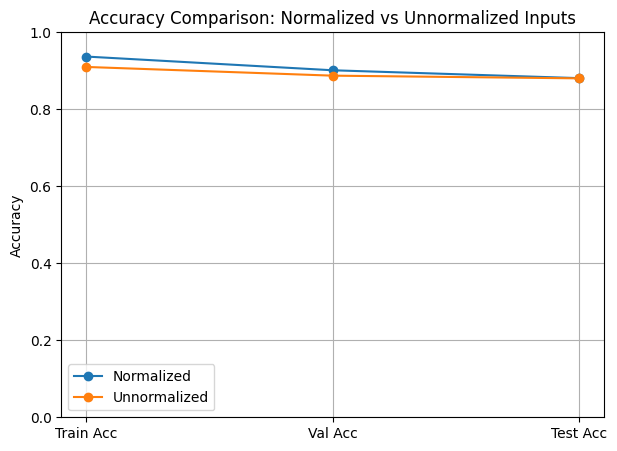

In [41]:
labels = ["Train Acc", "Val Acc", "Test Acc"]

norm_values = [acc_norm[k] for k in labels]
unnorm_values = [acc_unnorm[k] for k in labels]

plt.figure(figsize=(7,5))
plt.plot(labels, norm_values, marker='o', label="Normalized")
plt.plot(labels, unnorm_values, marker='o', label="Unnormalized")

plt.title("Accuracy Comparison: Normalized vs Unnormalized Inputs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


overall performing worse than normalized

[2×256 ReLU unnormalized] time: 45.3s | train: 90.70% | val: 88.85% | test: 87.57%

### 5

Re-train the MLP from question 3 on a version of FashionMNIST using data augmentation. You can use the `transforms.Compose()` function to set your transformations for data augmentation, and the `transform=train_transform` argument in the dataset constructor to set the transforms.

* Is the accuracy affected, and how?
* What are the benefits and/or drawbacks of using data augmentation?
* Can you think of a situation in which certain types data augmentation would be harmful?

In [32]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),          # flip half of the images
    transforms.RandomRotation(degrees=15),           # rotate ±15 degrees
    transforms.ToTensor(),                            # convert to [0,1] float32
    transforms.Lambda(lambda x: x.view(-1)),         # flatten to [784]
])

train_dataset_aug = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_aug
)

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset_aug))
val_size = len(train_dataset_aug) - train_size
train_dataset, val_dataset = random_split(train_dataset_aug, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=n_threads)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False, num_workers=n_threads)

test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Lambda(lambda x: x.view(-1))])
)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=n_threads)
X_train_e5, y_train_e5 = loader_to_numpy(train_loader)
X_val_e5,   y_val_e5   = loader_to_numpy(val_loader)
X_test_e5,  y_test_e5  = loader_to_numpy(test_loader)


In [42]:
optimizer_e5 = SGD(learning_rate=0.05,  max_epochs=40, batch_size=256, shuffle=True)
model_e5 = MLP(input_dim=input_dim, hidden_sizes=hidden, num_classes=num_classes,
                 activation='relu', l1=3e-05, seed=123)
res = train_and_eval(model_e5, optimizer_e4, X_train_e5, y_train_e5, X_val_e5, y_val_e5, X_test_e5, y_test_e5, label="2×256 ReLU unnormalized")
acc_augmented = {
    "Train Acc": res["train accuracy"],
    "Val Acc": res["val accuracy"],
    "Test Acc": res["test accuracy"],
}
df = pd.DataFrame([acc_norm, acc_unnorm], index=["Normalized", "Unnormalized"])
print(df)

[2×256 ReLU unnormalized] time: 32.8s | train accuracy: 88.82% | val accuracy: 85.50% | test accuracy: 85.32%
              Train Acc   Val Acc  Test Acc
Normalized     0.936981  0.901333    0.8809
Unnormalized   0.910000  0.887333    0.8803


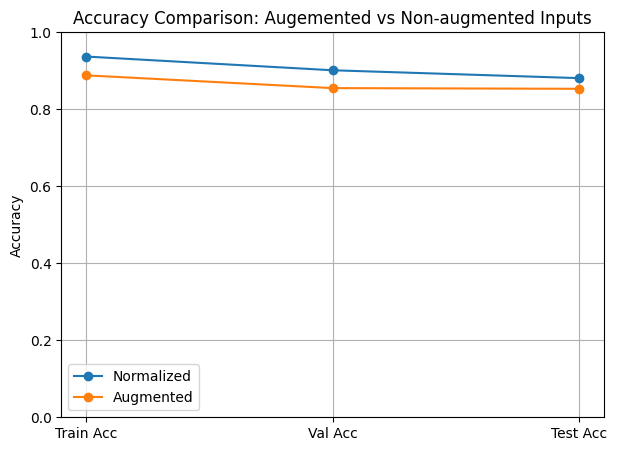

In [43]:
labels = ["Train Acc", "Val Acc", "Test Acc"]

norm_values = [acc_norm[k] for k in labels]
augmented_value = [acc_augmented[k] for k in labels]

plt.figure(figsize=(7,5))
plt.plot(labels, norm_values, marker='o', label="Normalized")
plt.plot(labels, augmented_value, marker='o', label="Augmented")

plt.title("Accuracy Comparison: Augemented vs Non-augmented Inputs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

Best Hyperparameters:

{'batch_size': 256, 'l1': 0.0, 'l2': 0, 'learning_rate': 0.05, 'max_epochs': 40}

Best CV Accuracy: 0.8373833333333334

Test accuracy with best params: 0.8246

hinders overall performance

### 6

Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2 convolutional layers, one fully connected hidden layer and one fully connected output layer. Although you are free in your choice of the hyperparameters of the convolutional layers, set the number of units in the fully connected layers to be 256. Also, set the activations in all of the layers to be ReLU. Train this CNN on the FashionMNIST dataset.

*   Does using a CNN increase/decrease the accuracy compared to using MLPs?
*   Provide comments on your results.

In [44]:
import torch.nn as nn
import torch.optim as optim

In [45]:
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset_full_cnn = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_cnn
)
test_dataset_cnn = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform_cnn
)


In [46]:
train_size_cnn = int((1 - val_ratio) * len(train_dataset_full_cnn))
val_size_cnn   = len(train_dataset_full_cnn) - train_size_cnn
batch_size_cnn = 256

In [47]:
train_dataset_cnn, val_dataset_cnn = random_split(
    train_dataset_full_cnn,
    [train_size_cnn, val_size_cnn],
)

In [48]:
train_loader_cnn = DataLoader(
    train_dataset_cnn, batch_size=batch_size_cnn, shuffle=True,  num_workers=n_threads
)
val_loader_cnn = DataLoader(
    val_dataset_cnn,   batch_size=batch_size_cnn, shuffle=False, num_workers=n_threads
)
test_loader_cnn = DataLoader(
    test_dataset_cnn,  batch_size=batch_size_cnn, shuffle=False, num_workers=n_threads
)

print(f"[CNN] Train: {len(train_dataset_cnn)}, Val: {len(val_dataset_cnn)}, Test: {len(test_dataset_cnn)}")

[CNN] Train: 54000, Val: 6000, Test: 10000


In [49]:
class FashionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1   = nn.Linear(64 * 7 * 7, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [50]:
def eval_cnn(model, loader, device):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            running_loss += loss.item() * xb.size(0)

            _, preds = outputs.max(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    return running_loss / total, correct / total

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_cnn = FashionCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

Using device: cuda


In [52]:
num_epochs = 15

train_hist_cnn = []
val_hist_cnn   = []

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    model_cnn.train()
    running_loss = 0.0
    correct, total = 0, 0

    for xb, yb in train_loader_cnn:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        _, preds = outputs.max(1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    val_loss, val_acc = eval_cnn(model_cnn, val_loader_cnn, device)

    train_hist_cnn.append((train_loss, train_acc))
    val_hist_cnn.append((val_loss, val_acc))

    print(
        f"[Epoch {epoch:02d}] "
        f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%"
    )

total_time = time.time() - start_time
print(f"Training time (CNN): {total_time:.1f}s")

[Epoch 01] train_loss=0.5522, train_acc=80.43% | val_loss=0.3582, val_acc=87.25%
[Epoch 02] train_loss=0.3389, train_acc=87.94% | val_loss=0.3040, val_acc=88.95%
[Epoch 03] train_loss=0.2948, train_acc=89.45% | val_loss=0.2776, val_acc=89.58%
[Epoch 04] train_loss=0.2544, train_acc=90.82% | val_loss=0.2427, val_acc=91.00%
[Epoch 05] train_loss=0.2264, train_acc=91.78% | val_loss=0.2249, val_acc=91.72%
[Epoch 06] train_loss=0.2065, train_acc=92.43% | val_loss=0.2150, val_acc=92.05%
[Epoch 07] train_loss=0.1893, train_acc=93.29% | val_loss=0.2117, val_acc=92.23%
[Epoch 08] train_loss=0.1731, train_acc=93.74% | val_loss=0.2163, val_acc=91.93%
[Epoch 09] train_loss=0.1591, train_acc=94.15% | val_loss=0.2177, val_acc=91.90%
[Epoch 10] train_loss=0.1412, train_acc=94.90% | val_loss=0.2074, val_acc=92.63%
[Epoch 11] train_loss=0.1284, train_acc=95.41% | val_loss=0.2078, val_acc=92.67%
[Epoch 12] train_loss=0.1170, train_acc=95.74% | val_loss=0.2135, val_acc=92.48%
[Epoch 13] train_loss=0.1021

In [53]:
test_loss_cnn, test_acc_cnn = eval_cnn(model_cnn, test_loader_cnn, device)
print(f"[CNN] Test loss={test_loss_cnn:.4f}, Test accuracy={test_acc_cnn*100:.2f}%")

[CNN] Test loss=0.2563, Test accuracy=92.26%


CNN 128x128

In [93]:
class FashionCNN128(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(64 * 32 * 32, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [96]:
transform_cnn_128 = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [97]:

train_dataset_full_cnn_128 = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_cnn_128
)
test_dataset_cnn_128 = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform_cnn_128
)

train_size_cnn_128 = int((1 - val_ratio) * len(train_dataset_full_cnn_128))
val_size_cnn_128   = len(train_dataset_full_cnn_128) - train_size_cnn_128
batch_size_cnn_128 = 256

train_dataset_cnn_128, val_dataset_cnn_128 = random_split(
    train_dataset_full_cnn_128,
    [train_size_cnn_128, val_size_cnn_128],
    generator=torch.Generator().manual_seed(42),
)

train_loader_cnn_128 = DataLoader(
    train_dataset_cnn_128, batch_size=batch_size_cnn_128, shuffle=True,  num_workers=n_threads
)
val_loader_cnn_128 = DataLoader(
    val_dataset_cnn_128,   batch_size=batch_size_cnn_128, shuffle=False, num_workers=n_threads
)
test_loader_cnn_128 = DataLoader(
    test_dataset_cnn_128,  batch_size=batch_size_cnn_128, shuffle=False, num_workers=n_threads
)

print(f"[CNN-128] Train: {len(train_dataset_cnn_128)}, Val: {len(val_dataset_cnn_128)}, Test: {len(test_dataset_cnn_128)}")


[CNN-128] Train: 54000, Val: 6000, Test: 10000


In [98]:
def train_cnn_128_for_epochs(num_epochs):
    model = FashionCNN128(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for xb, yb in train_loader_cnn_128:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            _, preds = outputs.max(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)

        train_loss = running_loss / total
        train_acc  = correct / total
        print(f"[CNN-128 Epoch {epoch:02d}] train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}%")

    total_time = time.time() - start_time

    train_loss_final, train_acc_final = eval_cnn(model, train_loader_cnn_128, device)
    test_loss_final,  test_acc_final  = eval_cnn(model, test_loader_cnn_128,  device)

    return {
        "num_epochs": num_epochs,
        "train_loss": train_loss_final,
        "test_loss":  test_loss_final,
        "train_acc":  train_acc_final,
        "test_acc":   test_acc_final,
        "train_time": total_time,
    }


In [99]:
res_cnn_128  = train_cnn_128_for_epochs(15)

[CNN-128 Epoch 01] train_loss=0.5620, train_acc=81.64%
[CNN-128 Epoch 02] train_loss=0.2965, train_acc=89.40%
[CNN-128 Epoch 03] train_loss=0.2370, train_acc=91.42%
[CNN-128 Epoch 04] train_loss=0.1977, train_acc=92.78%
[CNN-128 Epoch 05] train_loss=0.1618, train_acc=94.08%
[CNN-128 Epoch 06] train_loss=0.1312, train_acc=95.23%
[CNN-128 Epoch 07] train_loss=0.1036, train_acc=96.26%
[CNN-128 Epoch 08] train_loss=0.0771, train_acc=97.29%
[CNN-128 Epoch 09] train_loss=0.0586, train_acc=97.90%
[CNN-128 Epoch 10] train_loss=0.0438, train_acc=98.48%
[CNN-128 Epoch 11] train_loss=0.0377, train_acc=98.68%
[CNN-128 Epoch 12] train_loss=0.0289, train_acc=99.03%
[CNN-128 Epoch 13] train_loss=0.0220, train_acc=99.28%
[CNN-128 Epoch 14] train_loss=0.0164, train_acc=99.51%
[CNN-128 Epoch 15] train_loss=0.0169, train_acc=99.41%


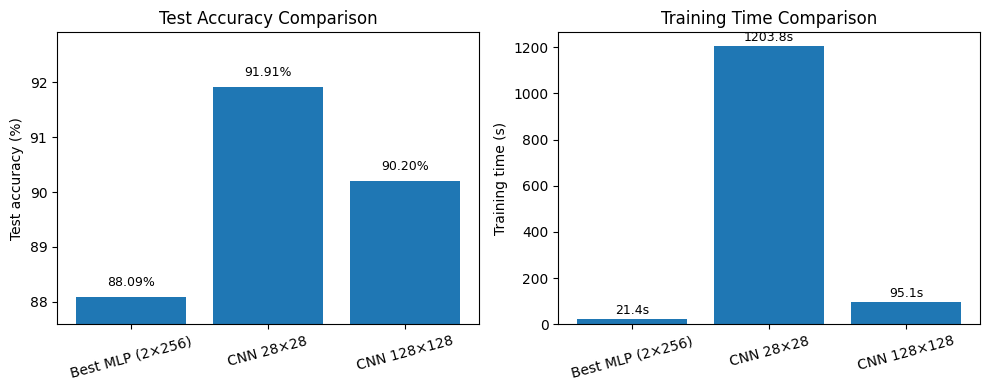

In [101]:
mlp_best_acc  = resC["test accuracy"] * 100     # percentage
mlp_best_time = resC["time"]                    # seconds

cnn28_acc  = acc_no_aug * 100                   # percentage
cnn28_time = time_no_aug                        # seconds

cnn128_acc  = res_cnn_128["test_acc"] * 100     # percentage
cnn128_time = res_cnn_128["train_time"]         # seconds

models   = ["Best MLP (2×256)", "CNN 28×28", "CNN 128×128"]
acc_vals = [mlp_best_acc, cnn28_acc, cnn128_acc]
time_vals = [mlp_best_time, cnn28_time, cnn128_time]

plt.figure(figsize=(10, 4))

# --- Accuracy plot ---
plt.subplot(1, 2, 1)
bars1 = plt.bar(models, acc_vals)
plt.ylabel("Test accuracy (%)")
plt.title("Test Accuracy Comparison")

for bar, val in zip(bars1, acc_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f"{val:.2f}%", ha="center", fontsize=9)

plt.ylim(min(acc_vals) - 0.5, max(acc_vals) + 1.0)
plt.xticks(rotation=15)

# --- Training time plot ---
plt.subplot(1, 2, 2)
bars2 = plt.bar(models, time_vals)
plt.ylabel("Training time (s)")
plt.title("Training Time Comparison")

for bar, val in zip(bars2, time_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02*max(time_vals),
             f"{val:.1f}s", ha="center", fontsize=9)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


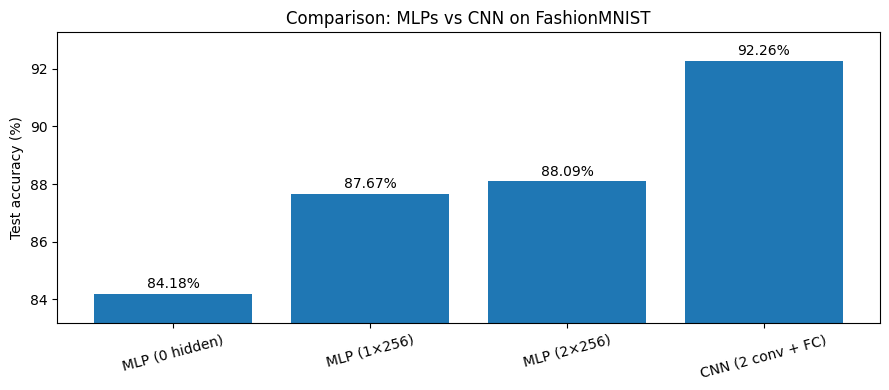

In [54]:
results = [
    ("MLP (0 hidden)",     resA["test accuracy"]),
    ("MLP (1×256)",        resB["test accuracy"]),
    ("MLP (2×256)",        resC["test accuracy"]),
    ("CNN (2 conv + FC)",  test_acc_cnn),   # already computed in Q6
]

model_names  = [name for name, acc in results]
test_accs    = [acc * 100 for name, acc in results]   # convert to %

plt.figure(figsize=(9,4))
plt.bar(model_names, test_accs)
plt.ylabel("Test accuracy (%)")
plt.title("Comparison: MLPs vs CNN on FashionMNIST")

for x, y in zip(model_names, test_accs):
    plt.text(x, y + 0.2, f"{y:.2f}%", ha="center", fontsize=10)

plt.ylim(min(test_accs)-1, max(test_accs)+1)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



### 7

Train the above CNN using FashionMNIST with the data augmentation from Q5.

*   How is the performance (accuracy and speed) affected?

In [55]:
# Q5 data augmentation

transform_cnn_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [56]:
# Validation - no augmentation to avoid leakage

transform_cnn_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [57]:
train_dataset_full_clean = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_cnn_val
)

test_dataset_cnn_aug = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform_cnn_val
)

train_dataset_full_aug = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_cnn_aug  # augmentation
)


In [58]:
# Split index in validation and training

import random

n_samples = len(train_dataset_full_clean)
all_indices = list(range(n_samples))
random.shuffle(all_indices)
train_size_cnn = int((1 - val_ratio) * n_samples)
train_indices = all_indices[:train_size_cnn]
val_indices   = all_indices[train_size_cnn:]

In [59]:
# Create validation set (no augmentation) and training set (augmentation) based on the index

from torch.utils.data import Subset

train_dataset_cnn = Subset(train_dataset_full_aug, train_indices)
val_dataset_cnn   = Subset(train_dataset_full_clean, val_indices)

In [60]:
train_loader_cnn_aug = DataLoader(
    train_dataset_cnn, batch_size=256,
    shuffle=True, num_workers=n_threads
)

val_loader_cnn_aug = DataLoader(
    val_dataset_cnn, batch_size=256,
    shuffle=False, num_workers=n_threads
)

test_loader_cnn_aug = DataLoader(
    test_dataset_cnn_aug, batch_size=256,
    shuffle=False, num_workers=n_threads
)



In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_cnn_aug = FashionCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn_aug = optim.Adam(model_cnn_aug.parameters(), lr=1e-3)

Using device: cuda


In [62]:
num_epochs = 15

train_hist_cnn = []
val_hist_cnn   = []

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    model_cnn_aug.train()
    running_loss = 0.0
    correct, total = 0, 0

    for xb, yb in train_loader_cnn_aug:
        xb, yb = xb.to(device), yb.to(device)

        optimizer_cnn_aug.zero_grad()
        outputs = model_cnn_aug(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer_cnn_aug.step()

        running_loss += loss.item() * xb.size(0)
        _, preds = outputs.max(1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    val_loss, val_acc = eval_cnn(model_cnn_aug, val_loader_cnn_aug, device)

    train_hist_cnn.append((train_loss, train_acc))
    val_hist_cnn.append((val_loss, val_acc))

    print(
        f"[Epoch {epoch:02d}] "
        f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%"
    )

total_time = time.time() - start_time
print(f"Training time (CNN AUG): {total_time:.1f}s")

test_loss_cnn, test_acc_cnn = eval_cnn(model_cnn_aug, test_loader_cnn_aug, device)
print(f"[CNN AUG] Test loss={test_loss_cnn:.4f}, Test accuracy={test_acc_cnn*100:.2f}%")


[Epoch 01] train_loss=0.6349, train_acc=77.35% | val_loss=0.4233, val_acc=84.32%
[Epoch 02] train_loss=0.4104, train_acc=85.12% | val_loss=0.3307, val_acc=88.47%
[Epoch 03] train_loss=0.3571, train_acc=86.81% | val_loss=0.3019, val_acc=88.85%
[Epoch 04] train_loss=0.3226, train_acc=88.07% | val_loss=0.2775, val_acc=89.67%
[Epoch 05] train_loss=0.2951, train_acc=89.06% | val_loss=0.2793, val_acc=89.52%
[Epoch 06] train_loss=0.2814, train_acc=89.66% | val_loss=0.2739, val_acc=90.02%
[Epoch 07] train_loss=0.2661, train_acc=90.17% | val_loss=0.2441, val_acc=90.93%
[Epoch 08] train_loss=0.2535, train_acc=90.71% | val_loss=0.2385, val_acc=91.25%
[Epoch 09] train_loss=0.2430, train_acc=90.96% | val_loss=0.2318, val_acc=91.55%
[Epoch 10] train_loss=0.2365, train_acc=91.27% | val_loss=0.2285, val_acc=91.70%
[Epoch 11] train_loss=0.2222, train_acc=91.79% | val_loss=0.2175, val_acc=92.18%
[Epoch 12] train_loss=0.2197, train_acc=91.81% | val_loss=0.2198, val_acc=91.97%
[Epoch 13] train_loss=0.2099

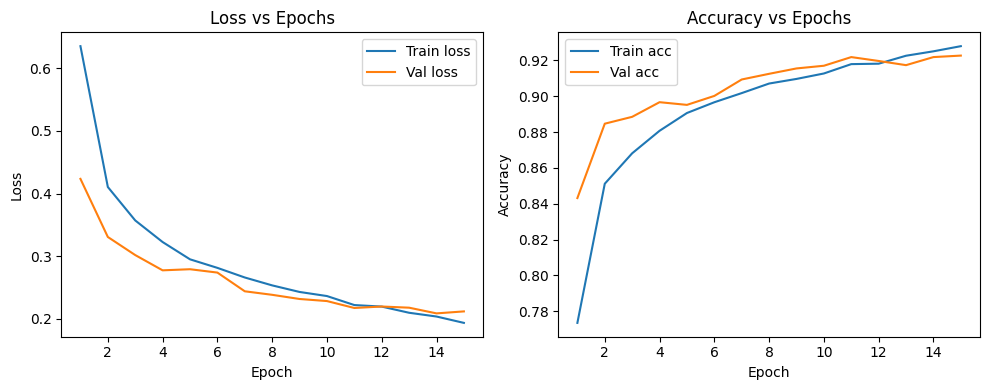

In [63]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

train_losses = [h[0] for h in train_hist_cnn]
train_accs   = [h[1] for h in train_hist_cnn]
val_losses   = [h[0] for h in val_hist_cnn]
val_accs     = [h[1] for h in val_hist_cnn]

plt.figure(figsize=(10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train acc")
plt.plot(epochs, val_accs, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()

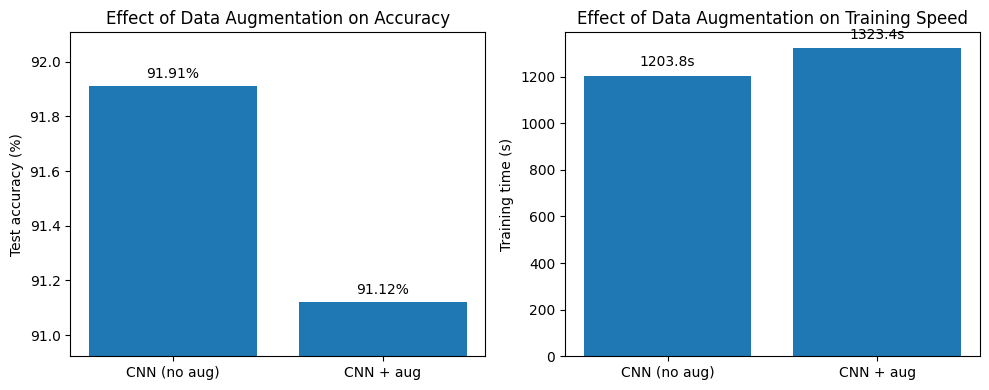

In [107]:
def plot_experiment7(results):
    """
    results: dict in the form
        {
          "CNN (no aug)": {"test_acc": acc_no_aug, "train_time": time_no_aug},
          "CNN + aug":    {"test_acc": acc_aug,    "train_time": time_aug}
        }
    where accuracies are in [0,1].
    """

    models = list(results.keys())
    acc_values = [results[m]["test_acc"] * 100 for m in models]   # to %
    time_values = [results[m]["train_time"] for m in models]

    acc_min, acc_max = min(acc_values), max(acc_values)
    acc_padding = (acc_max - acc_min) * 0.25
    if acc_padding == 0:
        acc_padding = 0.1
    acc_ymin = acc_min - acc_padding
    acc_ymax = acc_max + acc_padding

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.bar(models, acc_values)
    plt.ylabel("Test accuracy (%)")
    plt.title("Effect of Data Augmentation on Accuracy")
    plt.ylim(acc_ymin, acc_ymax)

    for x, y in zip(models, acc_values):
        plt.text(x, y + 0.02, f"{y:.2f}%", ha="center", va="bottom", fontsize=10)

    plt.subplot(1, 2, 2)
    plt.bar(models, time_values)
    plt.ylabel("Training time (s)")
    plt.title("Effect of Data Augmentation on Training Speed")

    time_offset = 0.02 * max(time_values)
    for x, y in zip(models, time_values):
        plt.text(x, y + time_offset, f"{y:.1f}s", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.show()

results_exp7 = {
    "CNN (no aug)": {"test_acc": acc_no_aug, "train_time": time_no_aug},
    "CNN + aug":    {"test_acc": acc_aug,    "train_time": time_aug}
}

plot_experiment7(results_exp7)

### 8

Load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch, and then freeze all the convolutional layers and remove all the fully connected ones. Add a number of fully
connected layers of your choice right after the convolutional layers. Train only the fully connected layers of the pre-trained model on the FashionMNIST dataset with the data augmentation from Q5.

- How does this pre-trained model compare to the best MLP in part 5 and to the CNN in part 7 in terms of accuracy?
- How does it compare to the previous models in terms of the required training time?
- Justify your choice of how many fully connected layers that you have added to the pre-trained model through careful experiments



In [65]:
import torchvision.models as models

In [66]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

transform_resnet_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

transform_resnet_eval = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),
    transforms.Normalize(imagenet_mean, imagenet_std),
])


In [67]:
train_dataset_full_resnet = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_resnet_train
)

test_dataset_resnet = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform_resnet_eval
)

In [68]:
train_size_resnet = int((1 - val_ratio) * len(train_dataset_full_resnet))
val_size_resnet   = len(train_dataset_full_resnet) - train_size_resnet

train_dataset_resnet, val_dataset_resnet = random_split(
    train_dataset_full_resnet,
    [train_size_resnet, val_size_resnet],
    generator=torch.Generator().manual_seed(123)
)

In [69]:
batch_size_resnet = 128

In [70]:
train_loader_resnet = DataLoader(
    train_dataset_resnet, batch_size=batch_size_resnet,
    shuffle=True, num_workers=n_threads
)
val_loader_resnet = DataLoader(
    val_dataset_resnet, batch_size=batch_size_resnet,
    shuffle=False, num_workers=n_threads
)
test_loader_resnet = DataLoader(
    test_dataset_resnet, batch_size=batch_size_resnet,
    shuffle=False, num_workers=n_threads
)

print(f"[ResNet] Train: {len(train_dataset_resnet)}, Val: {len(val_dataset_resnet)}, Test: {len(test_dataset_resnet)}")


[ResNet] Train: 54000, Val: 6000, Test: 10000


In [71]:
try:
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
except:
    resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 235MB/s]


In [72]:
def eval_model(model, loader, device):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion_resnet(outputs, yb)
            running_loss += loss.item() * xb.size(0)

            _, preds = outputs.max(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    return running_loss / total, correct / total

#### Justify your choice of how many fully connected layers that you have added to the pre-trained model through careful experiments

In [73]:
def make_head(head_type: str, in_features: int, num_classes: int = 10):
    if head_type == "linear":
        return nn.Linear(in_features, num_classes)

    elif head_type == "1_hidden":
        return nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    elif head_type == "2_hidden":
        return nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )


In [74]:
def create_resnet_with_head(head_type: str, num_classes: int = 10):
    try:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    except:
        model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.fc.in_features

    model.fc = make_head(head_type, in_features, num_classes)

    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)


In [75]:
criterion_resnet = nn.CrossEntropyLoss()

In [76]:
def train_resnet_head(model, head_name: str,
                      train_loader, val_loader,
                      device,
                      num_epochs: int = 5,
                      lr: float = 1e-3):

    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr
    )

    train_hist = []
    val_hist   = []

    print(f"\nTraining {head_name}")
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion_resnet(outputs, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            _, preds = outputs.max(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)

        train_loss = running_loss / total
        train_acc  = correct / total

        val_loss, val_acc = eval_model(model, val_loader, device)

        train_hist.append((train_loss, train_acc))
        val_hist.append((val_loss, val_acc))

        print(
            f"[{head_name} Epoch {epoch:02d}] "
            f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%"
        )

    total_time = time.time() - start_time
    print(f"Total time ({head_name}): {total_time:.1f}s")

    return {
        "train_hist": train_hist,
        "val_hist": val_hist,
        "time": total_time,
        "model": model,
    }


In [77]:
head_types = ["linear", "1_hidden", "2_hidden"]
results_resnet_heads = {}

num_epochs_head = 3 # just to try

for head_name in head_types:
    resnet_head = create_resnet_with_head(head_name, num_classes=10)

    res = train_resnet_head(
        resnet_head,
        head_name,
        train_loader_resnet,
        val_loader_resnet,
        device,
        num_epochs=num_epochs_head,
        lr=1e-3,
    )

    test_loss, test_acc = eval_model(resnet_head, test_loader_resnet, device)

    results_resnet_heads[head_name] = {
        "train_hist": res["train_hist"],
        "val_hist":   res["val_hist"],
        "time":       res["time"],
        "test_loss":  test_loss,
        "test_acc":   test_acc,
    }

    print(f"[{head_name}] Test loss={test_loss:.4f}, Test acc={test_acc*100:.2f}%")


Training linear
[linear Epoch 01] train_loss=0.8171, train_acc=73.98% | val_loss=0.5942, val_acc=79.20%
[linear Epoch 02] train_loss=0.5651, train_acc=80.58% | val_loss=0.5276, val_acc=80.95%
[linear Epoch 03] train_loss=0.5270, train_acc=81.39% | val_loss=0.5044, val_acc=82.18%
Total time (linear): 72.9s
[linear] Test loss=0.4622, Test acc=83.62%

Training 1_hidden
[1_hidden Epoch 01] train_loss=0.7853, train_acc=72.28% | val_loss=0.5416, val_acc=80.25%
[1_hidden Epoch 02] train_loss=0.5898, train_acc=78.72% | val_loss=0.5022, val_acc=81.53%
[1_hidden Epoch 03] train_loss=0.5607, train_acc=80.08% | val_loss=0.4803, val_acc=82.63%
Total time (1_hidden): 73.3s
[1_hidden] Test loss=0.4410, Test acc=84.09%

Training 2_hidden
[2_hidden Epoch 01] train_loss=0.6891, train_acc=75.70% | val_loss=0.5225, val_acc=80.55%
[2_hidden Epoch 02] train_loss=0.5211, train_acc=81.24% | val_loss=0.5011, val_acc=81.15%
[2_hidden Epoch 03] train_loss=0.4794, train_acc=82.57% | val_loss=0.4657, val_acc=83.0

In [92]:

head_meta = {
    "linear":   {"fc_layers": 1, "description": "Single linear layer"},
    "1_hidden": {"fc_layers": 2, "description": "1 hidden (256) + output"},
    "2_hidden": {"fc_layers": 3, "description": "2 hidden (256, 128) + output"},
}

rows = []
for head_name, res in results_resnet_heads.items():
    meta = head_meta.get(head_name, {"fc_layers": None, "description": ""})
    rows.append({
        "Head": head_name,
        "# FC layers": meta["fc_layers"],
        "Description": meta["description"],
        "Test accuracy (%)": res["test_acc"] * 100,
        "Training time (s)": res["time"],
    })

df_heads = (
    pd.DataFrame(rows)
    .sort_values("Test accuracy (%)", ascending=False)
    .reset_index(drop=True)
)

print(df_heads)

print("\nMarkdown table:\n")
print(df_heads.to_markdown(index=False, floatfmt=".2f"))

       Head  # FC layers                   Description  Test accuracy (%)  \
0  2_hidden            3  2 hidden (256, 128) + output              84.93   
1  1_hidden            2       1 hidden (256) + output              84.09   
2    linear            1           Single linear layer              83.62   

   Training time (s)  
0          73.255441  
1          73.291725  
2          72.907059  

Markdown table:

| Head     |   # FC layers | Description                  |   Test accuracy (%) |   Training time (s) |
|:---------|--------------:|:-----------------------------|--------------------:|--------------------:|
| 2_hidden |             3 | 2 hidden (256, 128) + output |               84.93 |               73.26 |
| 1_hidden |             2 | 1 hidden (256) + output      |               84.09 |               73.29 |
| linear   |             1 | Single linear layer          |               83.62 |               72.91 |


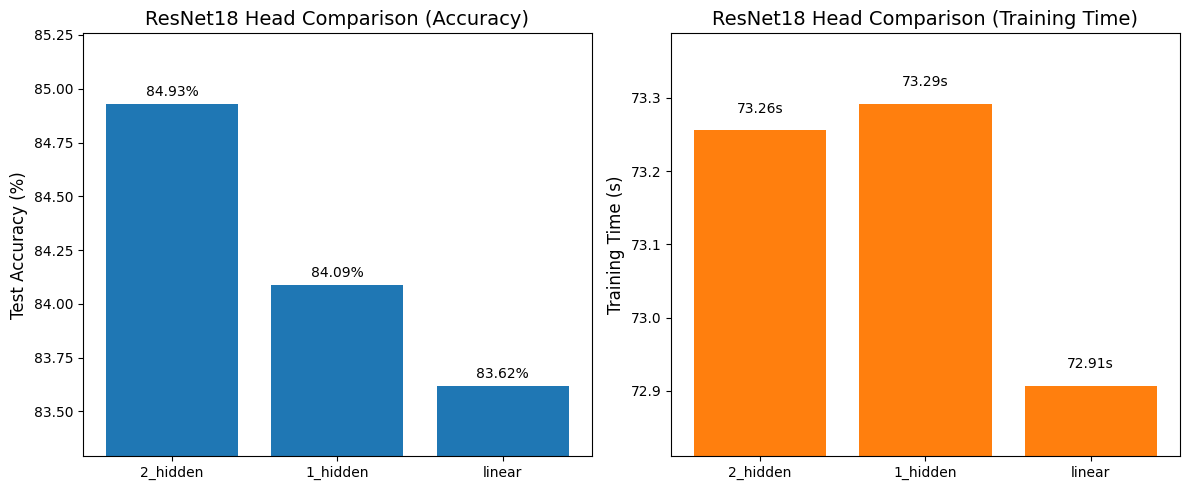

In [106]:

heads = df_heads["Head"].tolist()
accs  = df_heads["Test accuracy (%)"].tolist()
times = df_heads["Training time (s)"].tolist()

def zoom_limits(values, padding_ratio=0.25):
    vmin, vmax = min(values), max(values)
    padding = (vmax - vmin) * padding_ratio
    if padding == 0:
        padding = 0.1
    return vmin - padding, vmax + padding

acc_ymin, acc_ymax = zoom_limits(accs)
time_ymin, time_ymax = zoom_limits(times)

plt.figure(figsize=(12,5))

# ---- ACCURACY PLOT ----
plt.subplot(1,2,1)
bars = plt.bar(heads, accs, color='tab:blue')
plt.ylim(acc_ymin, acc_ymax)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.title("ResNet18 Head Comparison (Accuracy)", fontsize=14)

# Add value labels
for i, v in enumerate(accs):
    plt.text(i, v + 0.02, f"{v:.2f}%",
             ha='center', va='bottom', fontsize=10)

# ---- TIME PLOT ----
plt.subplot(1,2,2)
bars = plt.bar(heads, times, color='tab:orange')
plt.ylim(time_ymin, time_ymax)
plt.ylabel("Training Time (s)", fontsize=12)
plt.title("ResNet18 Head Comparison (Training Time)", fontsize=14)

for i, v in enumerate(times):
    plt.text(i, v + 0.02, f"{v:.2f}s",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#### Run the selected model

In [78]:
resnet_best = create_resnet_with_head("2_hidden", num_classes=10)


In [79]:
resnet_best_results = train_resnet_head(
    resnet_best,
    "best_model",
    train_loader_resnet,
    val_loader_resnet,
    device,
    num_epochs=15,
    lr=1e-3,
)



Training best_model
[best_model Epoch 01] train_loss=0.6965, train_acc=75.59% | val_loss=0.5292, val_acc=80.77%
[best_model Epoch 02] train_loss=0.5160, train_acc=81.27% | val_loss=0.4793, val_acc=83.08%
[best_model Epoch 03] train_loss=0.4836, train_acc=82.40% | val_loss=0.4573, val_acc=83.20%
[best_model Epoch 04] train_loss=0.4602, train_acc=83.14% | val_loss=0.4462, val_acc=83.13%
[best_model Epoch 05] train_loss=0.4410, train_acc=83.84% | val_loss=0.4367, val_acc=84.03%
[best_model Epoch 06] train_loss=0.4297, train_acc=84.26% | val_loss=0.4401, val_acc=83.95%
[best_model Epoch 07] train_loss=0.4188, train_acc=84.62% | val_loss=0.4230, val_acc=84.10%
[best_model Epoch 08] train_loss=0.4105, train_acc=84.88% | val_loss=0.4199, val_acc=84.50%
[best_model Epoch 09] train_loss=0.4034, train_acc=85.13% | val_loss=0.4152, val_acc=84.55%
[best_model Epoch 10] train_loss=0.3935, train_acc=85.51% | val_loss=0.4030, val_acc=85.00%
[best_model Epoch 11] train_loss=0.3897, train_acc=85.60% |

In [80]:
test_loss, test_acc = eval_model(resnet_best, test_loader_resnet, device)

print(f"Final Best Model Test Loss: {test_loss:.4f}")
print(f"Final Best Model Test Acc: {test_acc*100:.2f}%")


Final Best Model Test Loss: 0.3488
Final Best Model Test Acc: 87.19%


Plot

In [91]:
# --- Best MLP (part 5) ---
mlp_best_acc  = resC["test accuracy"] * 100      # accuracy in %
mlp_best_time = resC["time"]                     # training time in seconds

# --- CNN (part 7, with augmentation) ---
cnn_acc  = test_acc_cnn * 100                    # accuracy in %
cnn_time = total_time                            # "Training time (CNN AUG): ...s"

# --- Pre-trained ResNet18 (part 8) ---
resnet_acc  = test_acc * 100                     # from eval_model(resnet_best, ...)
resnet_time = resnet_best_results["time"]        # time returned by train_resnet_head

# --- Build comparison table ---
data = {
    "Model": [
        "Best MLP (2×256)",
        "CNN (with aug.)",
        "Pre-trained ResNet18",
    ],
    "Test Accuracy (%)": [
        mlp_best_acc,
        cnn_acc,
        resnet_acc,
    ],
    "Training Time (s)": [
        mlp_best_time,
        cnn_time,
        resnet_time,
    ],
}

df_models = pd.DataFrame(data)

print(df_models)

# Optional: markdown for easy copy-paste into report
print("\nMarkdown table:\n")
print(df_models.to_markdown(index=False, floatfmt=".2f"))


                  Model  Test Accuracy (%)  Training Time (s)
0      Best MLP (2×256)              88.09          21.398362
1       CNN (with aug.)              91.72          60.252386
2  Pre-trained ResNet18              87.19         365.497782

Markdown table:

| Model                |   Test Accuracy (%) |   Training Time (s) |
|:---------------------|--------------------:|--------------------:|
| Best MLP (2×256)     |               88.09 |               21.40 |
| CNN (with aug.)      |               91.72 |               60.25 |
| Pre-trained ResNet18 |               87.19 |              365.50 |


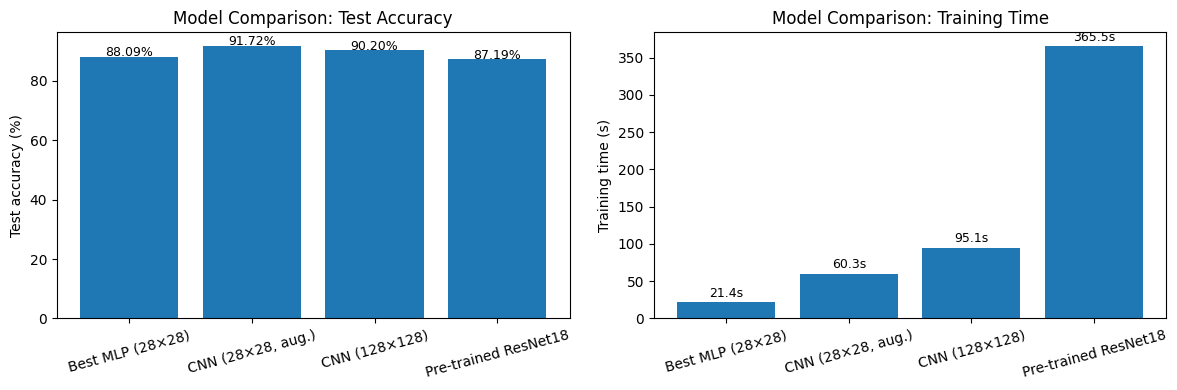

In [102]:
# === Comparison: Best MLP (28×28) vs CNN 28×28 vs CNN 128×128 vs Pre-trained ResNet18 ===

# Best MLP (part 5, 28×28)
mlp_acc  = resC["test accuracy"] * 100      # %
mlp_time = resC["time"]                     # seconds

# CNN 28×28 (here we use the best CNN from the augmentation experiment)
cnn28_acc  = test_acc_cnn * 100             # %
cnn28_time = total_time                     # seconds

# CNN 128×128 (from your train_cnn_128_for_epochs)
cnn128_acc  = res_cnn_128["test_acc"] * 100
cnn128_time = res_cnn_128["train_time"]

# Pre-trained ResNet18 (best head)
resnet_acc  = test_acc * 100
resnet_time = resnet_best_results["time"]

models     = [
    "Best MLP (28×28)",
    "CNN (28×28, aug.)",
    "CNN (128×128)",
    "Pre-trained ResNet18",
]
acc_values  = [mlp_acc, cnn28_acc, cnn128_acc, resnet_acc]
time_values = [mlp_time, cnn28_time, cnn128_time, resnet_time]

plt.figure(figsize=(12, 4))

# --- Accuracy subplot ---
plt.subplot(1, 2, 1)
bars1 = plt.bar(models, acc_values)
plt.ylabel("Test accuracy (%)")
plt.title("Model Comparison: Test Accuracy")
plt.xticks(rotation=15)

for bar, val in zip(bars1, acc_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.3,
        f"{val:.2f}%",
        ha="center",
        fontsize=9,
    )

# --- Training time subplot ---
plt.subplot(1, 2, 2)
bars2 = plt.bar(models, time_values)
plt.ylabel("Training time (s)")
plt.title("Model Comparison: Training Time")
plt.xticks(rotation=15)

for bar, val in zip(bars2, time_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.02 * max(time_values),
        f"{val:.1f}s",
        ha="center",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


### 9

You can report your findings either in the form of a table or a plot in the write-up. However, include in your colab notebooks the plots of the test and train performance of the MLPs / CNN / pre-trained model as a function of training epochs. This will allow you to see how much the network should be trained before it starts to overfit to the training data.


In [82]:
input_dim = 28 * 28
num_classes = 10
hidden = [256, 256]

In [83]:
def train_and_eval_epochs(model, X_train, y_train, X_test, y_test, n_epochs=10):
    optimizer = SGD(learning_rate=0.05,  max_epochs=n_epochs, batch_size=256, shuffle=True)
    print(f"Training start for {n_epochs} epochs")
    train_cost = model.fit(X_train, y_train, optimizer=optimizer)

    y_tr = model.predict(X_train)
    y_te = model.predict(X_test)

    train_cost_final = np.mean((y_train - y_tr)**2)
    test_cost_final = np.mean((y_test - y_te)**2)

    print(f"Final train cost: {train_cost_final:.4f} | Final test cost: {test_cost_final:.4f}")

    return {
        "max_epoch": n_epochs,
        "train_cost": train_cost_final,
        "test_cost": test_cost_final,
    }


In [84]:
model_e9 = MLP(input_dim=input_dim, hidden_sizes=hidden, num_classes=num_classes,
                 activation='relu', l1=3e-05, seed=123)
res_20 = train_and_eval_epochs(model_e9, X_train, y_train, X_test, y_test, n_epochs=20)
res_25 = train_and_eval_epochs(model_e9, X_train, y_train, X_test, y_test, n_epochs=25)
res_30 = train_and_eval_epochs(model_e9, X_train, y_train, X_test, y_test, n_epochs=30)
res_35 = train_and_eval_epochs(model_e9, X_train, y_train, X_test, y_test, n_epochs=35)
res_40 = train_and_eval_epochs(model_e9, X_train, y_train, X_test, y_test, n_epochs=40)
res_45 = train_and_eval_epochs(model_e9, X_train, y_train, X_test, y_test, n_epochs=45)
res_50 = train_and_eval_epochs(model_e9, X_train, y_train, X_test, y_test, n_epochs=50)


Training start for 20 epochs
Final train cost: 1.0531 | Final test cost: 1.5453
Training start for 25 epochs
Final train cost: 0.6310 | Final test cost: 1.4906
Training start for 30 epochs
Final train cost: 0.3968 | Final test cost: 1.5254
Training start for 35 epochs
Final train cost: 0.2261 | Final test cost: 1.4985
Training start for 40 epochs
Final train cost: 0.1256 | Final test cost: 1.4782
Training start for 45 epochs
Final train cost: 0.1994 | Final test cost: 1.5278
Training start for 50 epochs
Final train cost: 0.0550 | Final test cost: 1.4813


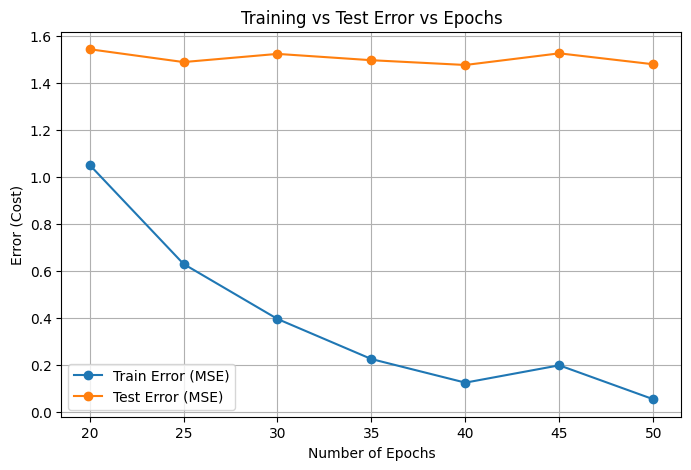

In [85]:
epochs = [20, 25, 30, 35, 40, 45, 50]

train_costs = [
    res_20["train_cost"],
    res_25["train_cost"],
    res_30["train_cost"],
    res_35["train_cost"],
    res_40["train_cost"],
    res_45["train_cost"],
    res_50["train_cost"],
]

test_costs = [
    res_20["test_cost"],
    res_25["test_cost"],
    res_30["test_cost"],
    res_35["test_cost"],
    res_40["test_cost"],
    res_45["test_cost"],
    res_50["test_cost"],
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_costs, marker='o', label='Train Error (MSE)')
plt.plot(epochs, test_costs, marker='o', label='Test Error (MSE)')
plt.xlabel("Number of Epochs")
plt.ylabel("Error (Cost)")
plt.title("Training vs Test Error vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
def train_cnn_for_epochs(num_epochs):
    model = FashionCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for xb, yb in train_loader_cnn:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            _, preds = outputs.max(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)

        train_loss = running_loss / total
        train_acc  = correct / total

    train_loss_final, train_acc_final = eval_cnn(model, train_loader_cnn, device)
    test_loss_final,  test_acc_final  = eval_cnn(model, test_loader_cnn,  device)

    return {
        "num_epochs": num_epochs,
        "train_loss": train_loss_final,
        "test_loss":  test_loss_final,
        "train_acc":  train_acc_final,
        "test_acc":   test_acc_final,
    }


In [87]:
epochs = [20, 25, 30, 35, 40, 45, 50] # duplicate for clarity

results = []
for ne in epochs:
    res = train_cnn_for_epochs(ne)
    print(f"Train loss: {res['train_loss']:.4f}, "
          f"Test loss: {res['test_loss']:.4f}, "
          f"Train acc: {res['train_acc']*100:.2f}%, "
          f"Test acc: {res['test_acc']*100:.2f}%")
    results.append(res)


Train loss: 0.0274, Test loss: 0.3152, Train acc: 99.20%, Test acc: 92.37%
Train loss: 0.0174, Test loss: 0.4422, Train acc: 99.44%, Test acc: 91.79%
Train loss: 0.0070, Test loss: 0.4675, Train acc: 99.82%, Test acc: 91.77%
Train loss: 0.0086, Test loss: 0.4931, Train acc: 99.76%, Test acc: 91.78%
Train loss: 0.0244, Test loss: 0.5162, Train acc: 99.15%, Test acc: 91.29%
Train loss: 0.0014, Test loss: 0.5962, Train acc: 99.96%, Test acc: 92.62%
Train loss: 0.0154, Test loss: 0.5664, Train acc: 99.48%, Test acc: 91.30%


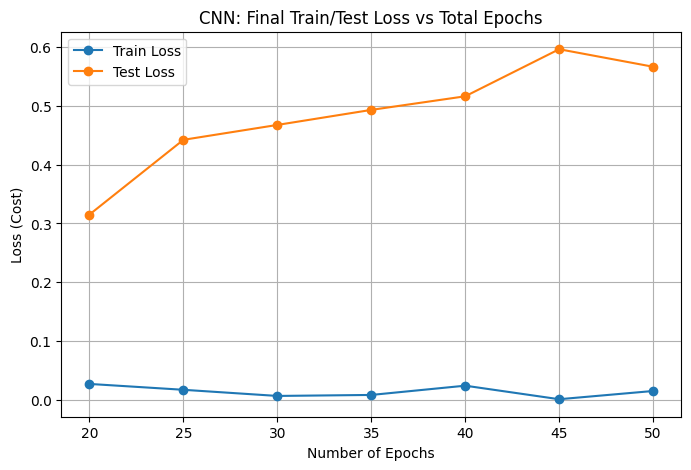

In [88]:
epochs = [r["num_epochs"] for r in results]
train_costs = [r["train_loss"] for r in results]
test_costs  = [r["test_loss"]  for r in results]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_costs, marker='o', label='Train Loss')
plt.plot(epochs, test_costs, marker='o', label='Test Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss (Cost)")
plt.title("CNN: Final Train/Test Loss vs Total Epochs")
plt.legend()
plt.grid(True)
plt.show()


## Extra experiments

### 10 - Early stopping

In [13]:
class SGD_early_stopping:
  def __init__(self, learning_rate=0.05, max_epochs=20, batch_size=128,
                shuffle=True, early_stopping_level=0):
      """
      early_stopping_level:
          0 = no early stopping
          1 = very aggressive (stop early)
          2 = moderate
          3 = less aggressive
          4 = almost full epochs
      """
      self.learning_rate = learning_rate
      self.max_epochs = max_epochs
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.early_stopping_level = early_stopping_level

      # Map early stopping level → patience
      self.level_to_patience = {0: None, 1: 3, 2: 5, 3: 10, 4: 20}

  def run(self, gradient_fn, X, y, params, X_val=None, y_val=None, model=None):
      N = X.shape[0]

      # Set patience
      patience = self.level_to_patience.get(self.early_stopping_level, 10)
      if patience is None:  # no early stopping
          patience = float("inf")

      best_params = [p.copy() for p in params]
      best_loss = float("inf")
      no_improve = 0

      for epoch in range(self.max_epochs):
          # Shuffle data
          idx = np.arange(N)
          if self.shuffle:
              np.random.shuffle(idx)

          # Mini-batch updates
          for start in range(0, N, self.batch_size):
              mb = idx[start:start + self.batch_size]
              grads = gradient_fn(X[mb], y[mb], params)
              for k in range(len(params)):
                  params[k] -= self.learning_rate * grads[k]

          # Compute validation loss for early stopping
          if model is not None and X_val is not None and y_val is not None:
              val_loss, _ = model._loss_and_grads(X_val, y_val, params)
          elif model is not None:
              val_loss, _ = model._loss_and_grads(X, y, params)
          else:
              val_loss = None  # can't compute loss → skip early stopping

          # Check improvement
          if val_loss is not None:
              if val_loss < best_loss - 1e-6:
                  best_loss = val_loss
                  best_params = [p.copy() for p in params]
                  no_improve = 0
              else:
                  no_improve += 1

              # Early stopping trigger
              if no_improve >= patience:
                  print(f"Early stopping at epoch {epoch}, patience={patience}")
                  return [p.copy() for p in best_params]

      return params

In [14]:
class MLP_early_stopping:
    _leaky_a = 0.01

    def __init__(self, input_dim, hidden_sizes, num_classes,
                 activation='relu', seed=42, l1=0.0, l2=0.0):
        self.input_dim = input_dim
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.activation = activation.lower()
        self.l1 = l1
        self.l2 = l2
        rng = np.random.default_rng(seed)

        # Layer sizes
        sizes = [self.input_dim] + self.hidden_sizes + [self.num_classes]
        self.params = []
        for i in range(len(sizes) - 1):
            W = rng.normal(0, np.sqrt(2.0 / sizes[i]), size=(sizes[i], sizes[i+1])).astype(np.float32)
            b = np.zeros((1, sizes[i+1]), dtype=np.float32)
            self.params += [W, b]

    # --- Activations ---
    @staticmethod
    def _relu(z): return np.maximum(0.0, z)
    @staticmethod
    def _relu_grad(z): return (z > 0).astype(np.float32)

    def _act(self, z):
        if self.activation == 'relu': return self._relu(z)
        raise ValueError("Unsupported activation")

    def _act_grad(self, z):
        if self.activation == 'relu': return self._relu_grad(z)
        raise ValueError("Unsupported activation")

    # --- Forward pass ---
    def _forward(self, X, params=None):
        if params is None: params = self.params
        L = len(params) // 2
        A = X
        caches = []
        for l in range(L):
            W, b = params[2*l], params[2*l+1]
            Z = A @ W + b
            if l < L - 1:
                A_next = self._act(Z)
            else:
                A_next = Z  # logits
            caches.append((A, Z, l))
            A = A_next
        return caches, A

    # --- Loss + gradients ---
    def _loss_and_grads(self, X, y, params):
        N = X.shape[0]
        caches, logits = self._forward(X, params)
        probs = softmax(logits)
        Y = one_hot(y, probs.shape[1])
        ce_loss = -np.sum(Y * np.log(probs + 1e-12)) / N

        # L1/L2 regularization
        l1_pen, l2_pen = 0.0, 0.0
        for i in range(0, len(params), 2):
            W = params[i]
            l1_pen += self.l1 * np.sum(np.abs(W))
            l2_pen += 0.5 * self.l2 * np.sum(W**2)

        loss = ce_loss + l1_pen + l2_pen

        # Backprop
        grads = [None] * len(params)
        dA = (probs - Y) / N
        L = len(params) // 2
        for l in reversed(range(L)):
            A_prev, Z, _ = caches[l]
            W, b = params[2*l], params[2*l+1]
            dW = A_prev.T @ dA + self.l2 * W
            db = np.sum(dA, axis=0, keepdims=True)
            grads[2*l], grads[2*l+1] = dW, db
            if l > 0:
                dA = (dA @ W.T) * self._act_grad(caches[l-1][1])
        return loss, grads


    def fit(self, X, y, optimizer, X_val=None, y_val=None):
      self.params = optimizer.run(
          lambda Xb, yb, p: self._loss_and_grads(Xb, yb, p)[1],
          X, y, self.params,
          X_val=X_val, y_val=y_val,
          model=self  # always pass model
      )
      return self


    # --- Predict ---
    def predict(self, X):
        _, logits = self._forward(X)
        return np.argmax(softmax(logits), axis=1)



=== Training with early_stopping_level=0 ===
Train Acc: 0.9416, Val Acc: 0.9033

=== Training with early_stopping_level=1 ===
Early stopping at epoch 17, patience=3
Train Acc: 0.9288, Val Acc: 0.8927

=== Training with early_stopping_level=2 ===
Early stopping at epoch 14, patience=5
Train Acc: 0.9160, Val Acc: 0.8945

=== Training with early_stopping_level=3 ===
Train Acc: 0.9356, Val Acc: 0.8950

=== Training with early_stopping_level=4 ===
Train Acc: 0.9394, Val Acc: 0.8977


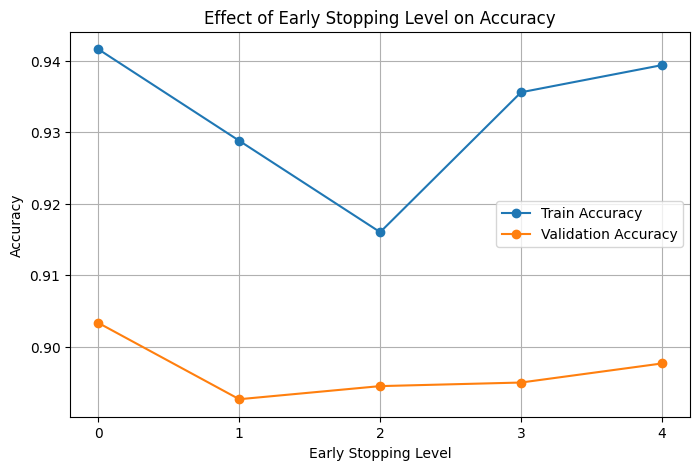

In [15]:
input_dim = 28 * 28
num_classes = 10
hidden = [256, 256]

early_levels = [0, 1, 2, 3, 4]

# Store results
train_acc_list = []
val_acc_list = []

for level in early_levels:
    print(f"\n=== Training with early_stopping_level={level} ===")

    # Create new optimizer
    opt = SGD_early_stopping(early_stopping_level=level)

    # Create new model
    model = MLP_early_stopping(
        input_dim=input_dim,
        hidden_sizes=hidden,
        num_classes=num_classes,
        activation='relu',
        seed=123
    )
    model.fit(X_train, y_train, optimizer=opt, X_val=X_val, y_val=y_val)

    # Predict on train and val
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)

    train_acc = evaluate_acc(y_train, y_train_pred)
    val_acc = evaluate_acc(y_val, y_val_pred)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# --- Plot results ---
plt.figure(figsize=(8,5))
plt.plot(early_levels, train_acc_list, marker='o', label="Train Accuracy")
plt.plot(early_levels, val_acc_list, marker='o', label="Validation Accuracy")
plt.xlabel("Early Stopping Level")
plt.ylabel("Accuracy")
plt.title("Effect of Early Stopping Level on Accuracy")
plt.xticks(early_levels)
plt.grid(True)
plt.legend()
plt.show()



### 11 - Random Dropout

In [16]:


input_dim   = 28 * 28
num_classes = 10
hidden      = [256, 256]

dropout_ps = [0.0, 0.1, 0.2, 0.5]
n_runs = 5  # number of random seeds per dropout rate

results = {}  # store stats per p

for p in dropout_ps:
    train_accs = []
    val_accs   = []
    test_accs  = []

    print(f"\n=== Dropout p={p} over {n_runs} runs ===")
    for run in range(n_runs):
        seed = 123 + run  # different seed each run

        opt = SGD(learning_rate=0.05, max_epochs=30, batch_size=256, shuffle=True)

        mlp = MLP(input_dim, hidden, num_classes,
                  activation='relu',
                  l1=0.0, l2=0.0,
                  dropout_rate=p,
                  seed=seed)

        res = train_and_eval(
            mlp, opt,
            X_train, y_train,
            X_val,   y_val,
            X_test,  y_test,
            label=f"Dropout p={p}, run={run}"
        )

        train_accs.append(res["train accuracy"])
        val_accs.append(res["val accuracy"])
        test_accs.append(res["test accuracy"])

        print(f"  run {run}: train={res['train accuracy']:.4f}, "
              f"val={res['val accuracy']:.4f}, test={res['test accuracy']:.4f}")

    # convert to numpy for stats
    train_accs = np.array(train_accs)
    val_accs   = np.array(val_accs)
    test_accs  = np.array(test_accs)

    results[p] = {
        "train_mean": train_accs.mean(),
        "train_std":  train_accs.std(),
        "val_mean":   val_accs.mean(),
        "val_std":    val_accs.std(),
        "test_mean":  test_accs.mean(),
        "test_std":   test_accs.std(),
    }

    print(f"\nSummary for p={p}:")
    print(f"  Train: mean={train_accs.mean():.4f}, std={train_accs.std():.4f}")
    print(f"  Val:   mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"  Test:  mean={test_accs.mean():.4f}, std={test_accs.std():.4f}")

print("\n=== Final Dropout Summary (means ± std) ===")
for p in dropout_ps:
    r = results[p]
    print(
        f"p={p:>3}: "
        f"train={r['train_mean']:.4f}±{r['train_std']:.4f}, "
        f"val={r['val_mean']:.4f}±{r['val_std']:.4f}, "
        f"test={r['test_mean']:.4f}±{r['test_std']:.4f}"
    )




=== Dropout p=0.0 over 5 runs ===
[Dropout p=0.0, run=0] time: 23.0s | train accuracy: 93.93% | val accuracy: 90.07% | test accuracy: 88.72%
  run 0: train=0.9393, val=0.9007, test=0.8872
[Dropout p=0.0, run=1] time: 21.0s | train accuracy: 93.59% | val accuracy: 90.13% | test accuracy: 88.62%
  run 1: train=0.9359, val=0.9013, test=0.8862
[Dropout p=0.0, run=2] time: 23.0s | train accuracy: 93.37% | val accuracy: 89.40% | test accuracy: 88.39%
  run 2: train=0.9337, val=0.8940, test=0.8839
[Dropout p=0.0, run=3] time: 23.3s | train accuracy: 92.34% | val accuracy: 88.62% | test accuracy: 87.47%
  run 3: train=0.9234, val=0.8862, test=0.8747
[Dropout p=0.0, run=4] time: 22.9s | train accuracy: 93.32% | val accuracy: 89.92% | test accuracy: 88.48%
  run 4: train=0.9332, val=0.8992, test=0.8848

Summary for p=0.0:
  Train: mean=0.9331, std=0.0053
  Val:   mean=0.8963, std=0.0057
  Test:  mean=0.8834, std=0.0045

=== Dropout p=0.1 over 5 runs ===
[Dropout p=0.1, run=0] time: 40.5s | trai

### 12 - Data augmentation techniques

The question of the experiment is "What is the best augmentation technique for this task?"

Because of the time to run the experiment, we shorlisted three augmentation techniques:
- **Scaling** (Geometric Transformation)
- **Brightness adjustment** (Color-Space augmentation)
- **Gaussian noise** (Noise-Based Augmentations)

Running on the CNN from experiment 6

In [17]:
aug_transforms = {
    "scaling": transforms.Compose([
        transforms.RandomResizedCrop(
            size=28,
            scale=(0.8, 1.2)
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),

    "brightness": transforms.Compose([
        transforms.ColorJitter(brightness=0.4),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),

    "gaussian_noise": transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}


In [18]:
# Validation - no augmentation to avoid leakage

transform_cnn_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [19]:
train_dataset_full_clean = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_cnn_val
)

test_dataset_cnn = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform_cnn_val
)


In [20]:
# Split index in validation and training

import random

n_samples = len(train_dataset_full_clean)
all_indices = list(range(n_samples))
random.shuffle(all_indices)
train_size_cnn = int((1 - val_ratio) * n_samples)
train_indices = all_indices[:train_size_cnn]
val_indices   = all_indices[train_size_cnn:]

In [21]:
# Create validation set (no augmentation)

from torch.utils.data import Subset

val_dataset_cnn   = Subset(train_dataset_full_clean, val_indices)

In [22]:
test_loader_cnn = DataLoader(
    test_dataset_cnn, batch_size=256,
    shuffle=False, num_workers=n_threads
)


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:

print("Using device:", device)

num_epochs = 15

results_cnn = {} # test accuracy per augmentation
hists_cnn   = {} # learning curves per augmentation to plot

for aug_name, transform_cnn_aug in aug_transforms.items():
    print(f"\n CNN with augmentation: {aug_name}")

    train_dataset_full_aug = datasets.FashionMNIST(
        root="./data", train=True, download=True, transform=transform_cnn_aug
    )

    train_dataset_cnn = Subset(train_dataset_full_aug, train_indices)

    train_loader_cnn = DataLoader(
        train_dataset_cnn, batch_size=256,
        shuffle=True, num_workers=n_threads
    )

    val_loader_cnn = DataLoader(
        val_dataset_cnn, batch_size=256,
        shuffle=False, num_workers=n_threads
    )

    model_cnn = FashionCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)

    train_hist_cnn = []
    val_hist_cnn   = []

    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        model_cnn.train()
        running_loss = 0.0
        correct, total = 0, 0

        for xb, yb in train_loader_cnn:
            xb, yb = xb.to(device), yb.to(device)

            optimizer_cnn.zero_grad()
            outputs = model_cnn(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer_cnn.step()

            running_loss += loss.item() * xb.size(0)
            _, preds = outputs.max(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)

        train_loss = running_loss / total
        train_acc  = correct / total

        val_loss, val_acc = eval_cnn(model_cnn, val_loader_cnn, device)

        train_hist_cnn.append((train_loss, train_acc))
        val_hist_cnn.append((val_loss, val_acc))

        print(
            f"[{aug_name} | Epoch {epoch:02d}] "
            f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%"
        )

    total_time = time.time() - start_time
    print(f"Training time ({aug_name}): {total_time:.1f}s")

    test_loss_cnn, test_acc_cnn = eval_cnn(model_cnn, test_loader_cnn, device)
    print(f"[{aug_name}] Test loss={test_loss_cnn:.4f}, Test accuracy={test_acc_cnn*100:.2f}%")

    results_cnn[aug_name] = (test_loss_cnn, test_acc_cnn)
    hists_cnn[aug_name]   = (train_hist_cnn, val_hist_cnn)

Using device: cuda

 CNN with augmentation: scaling
[scaling | Epoch 01] train_loss=0.6430, train_acc=76.18% | val_loss=0.3851, val_acc=86.10%
[scaling | Epoch 02] train_loss=0.4274, train_acc=84.23% | val_loss=0.3447, val_acc=87.37%
[scaling | Epoch 03] train_loss=0.3718, train_acc=86.26% | val_loss=0.3152, val_acc=88.30%
[scaling | Epoch 04] train_loss=0.3437, train_acc=87.40% | val_loss=0.2712, val_acc=89.97%
[scaling | Epoch 05] train_loss=0.3204, train_acc=87.95% | val_loss=0.2868, val_acc=89.45%
[scaling | Epoch 06] train_loss=0.3045, train_acc=88.76% | val_loss=0.2658, val_acc=89.95%
[scaling | Epoch 07] train_loss=0.2918, train_acc=89.11% | val_loss=0.2467, val_acc=90.43%
[scaling | Epoch 08] train_loss=0.2740, train_acc=89.72% | val_loss=0.2411, val_acc=90.93%
[scaling | Epoch 09] train_loss=0.2655, train_acc=90.11% | val_loss=0.2214, val_acc=91.38%
[scaling | Epoch 10] train_loss=0.2537, train_acc=90.55% | val_loss=0.2233, val_acc=91.78%
[scaling | Epoch 11] train_loss=0.2430

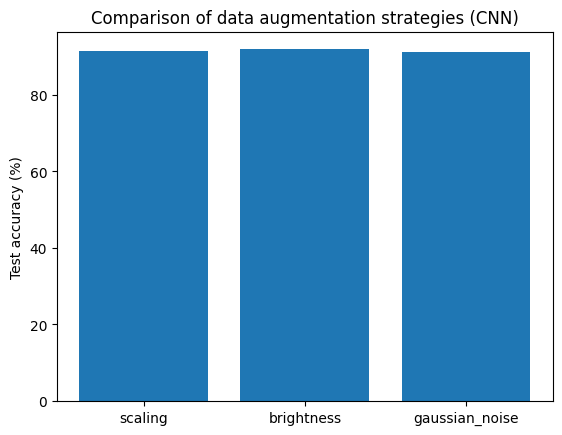

In [30]:
names = list(results_cnn.keys())
test_accs = [results_cnn[n][1] for n in names]

plt.bar(names, [a * 100 for a in test_accs])
plt.ylabel("Test accuracy (%)")
plt.title("Comparison of data augmentation strategies (CNN)")
plt.show()


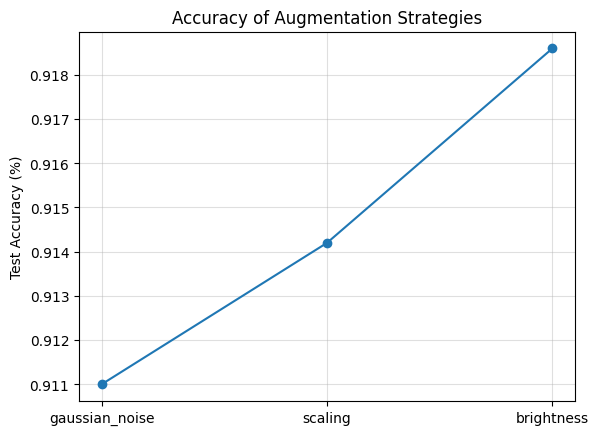

In [31]:
sorted_pairs = sorted(zip(names, test_accs), key=lambda x: x[1])
sorted_names, sorted_accs = zip(*sorted_pairs)

plt.plot(sorted_accs, marker='o')
plt.xticks(range(len(sorted_names)), sorted_names)
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy of Augmentation Strategies")
plt.grid(alpha=0.4)
plt.show()
